In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import time
import os
from permanents import glynn

In [14]:
device = torch.device("cpu")

n_sessions = 1000 # number of sessions per iteration
Learning_rate = 0.001 # learning rate, increase this to converge faster
percentile = 90 # top 100-x percentile the agent will learn from
super_percentile = 90 # top 100-x percentile of that survives to the next generation

n = 8

In [15]:
# helper function to add 3 of the 5 free points present in all 312-avoiding matrices
def add_free_points(input_state, n, step):
    action_taken = torch.zeros([len(input_state)])
    cur_state = torch.clone(input_state)

    if step == 1:
        action_index = 0
    elif step == 2:
        action_index = n**2-n
    else: # step == 3:
        action_index = n**2-1

    cur_state[action_index] = 1
    action_taken[action_index] = 1

    return cur_state, action_taken    

In [16]:
def convert_to_board(word, n):
    word = word.astype(np.float32)  # cast input array to float32
    board = np.zeros((n, n), dtype=np.float32)
    for i in range(len(word)):
        board[i//n, i%n] = word[i]
    return board

In [17]:
# Defining a helper function that takes in a game and outputs the final board state
def final_board_state(game):
    n = len(game)
    for i in range(len(game)):
        if i == 0:
            continue
        if i == n-1:
            return game[i]
        if game[i+1].sum() == 0 and game[i].sum() != 0:
            return game[i]

In [18]:
# helper function to add corners based on probability on the output of the corner_agent neural network
def add_corner(input_state, action_vec, n, row_boundary, col_boundary):
    corner_added = False
    action_taken = torch.zeros([len(action_vec)])
    cur_state = torch.clone(input_state)

    terminal = False

    while not corner_added:
        action_index = torch.multinomial(action_vec, 1).item()
        action_row = action_index//n
        action_col = action_index%n

        if (action_row == n-2 and action_col != n-1) or (action_col == 1 and action_row != 0) or (row_boundary == 0 and action_row != 0):
            action_vec[action_index] = 0
            action_vec = action_vec / torch.sum(action_vec)
        elif row_boundary <= action_row < n-1 and col_boundary <= action_col:
            cur_state[action_index] = 1
            action_taken[action_index] = 1
            corner_added = True
        else:
            action_vec[action_index] = 0
            action_vec = action_vec / torch.sum(action_vec)

    if action_col == n-1:
        terminal = True

    return cur_state, action_taken, terminal, action_row, action_col


In [19]:
# defines a helper function to add point, action_vec is the output, output = agent(cur_state), agent = net
def add_point(input_state, action_vec, forbidden_state, corners, n):
    
    ## add time
    point_added = False
    action_taken = torch.zeros([len(action_vec)])
    cur_state = torch.clone(input_state)
    cur_forbidden = torch.clone(forbidden_state)

    while not point_added:
        action_index = torch.multinomial(action_vec, 1).item()

        if cur_state[action_index] == 0 and cur_forbidden[action_index] != 1:
            # action
            cur_state[action_index] = 1
            action_taken[action_index] = 1
            point_added = True

            point_row = action_index//n
            point_col = action_index%n
            # fill forbidden
            for corner in corners:
                corner_row = corner//n
                corner_col = corner%n
                # fill left block
                if corner_row < point_row and point_col < corner_col:
                    for forbidden_row in range(corner_row+1, point_row):
                        for forbidden_col in range(point_col):
                            forbidden_index = forbidden_row*n + forbidden_col
                            if cur_state[forbidden_index] == 0:
                                cur_forbidden[forbidden_index] = 1
                    # fill right block
                    for forbidden_col in range(point_col+1, corner_col):
                        for forbidden_row in range(point_row+1, n):
                            forbidden_index = forbidden_row*n + forbidden_col
                            if cur_state[forbidden_index] == 0:
                                cur_forbidden[forbidden_index] = 1
        else:
            action_vec[action_index] = 0
            action_vec = action_vec / torch.sum(action_vec)

    return cur_state, action_taken, cur_forbidden

In [20]:
def generate_session(agent, corner_agent, n_sessions, n):
    # (nth session, always 4*n - 4 steps, always n*n board)
    states = torch.zeros((n_sessions, 4*n-4+1, n*n))
    actions = torch.zeros((n_sessions, 4*n-4+1, n*n))
    forbidden_points = torch.zeros((n_sessions, 4*n-4+1, n*n))
    corners = torch.zeros((n_sessions, 4*n-4+1, n*n))

    scores = torch.zeros([n_sessions])
    states.to(device)

    for i in range(n_sessions):
        step = 0

        while step < 3:
            step += 1
            cur_state = states[i,step-1, :]

            new_state, action = add_free_points(cur_state, n, step)
            
            actions[i,step-1, :] = action
            states[i,step, :] = new_state

        # add corners
        corner_num = 0
        corner_list = [0]*(n-1) # there can be at most n-2 corners

        row_boundary, col_boundary = 0, 1

        row_zero_set = False
        terminal = False
        while not terminal:
            step += 1
            cur_state = states[i,step-1, :]

            output = corner_agent(cur_state)

            new_state, action, terminal, row_added, col_added = add_corner(cur_state, output, n, row_boundary, col_boundary)
            
            # Ensures that a corner is always set in first row. If the lower block is entered, essentially sets (1,2), 1-indexed, as the first corner
            # then artifically using the above point as the next step. The lower black can only be entered once.
            '''if row_added == 0:
                row_zero_set = True
            if not row_zero_set:
                cur_state = torch.clone(states[i,step-1, :])
                cur_state[1] = 1

                actions[i,step-1, 1] = 1
                states[i,step, :] = cur_state
                corners[i,step, 1] = 1
            
                corner_list[corner_num] = 1 # the first corner is at index 1
                corner_num += 1
            
                step += 1
                row_zero_set = True

                new_state[1] = 1
            #need to account for attempted corners in second column, other than index 1 '''
            corner_index = row_added*n + col_added
            corner_list[corner_num] = corner_index
            corners[i,step, corner_index] = 1

            corner_num += 1

            row_boundary = row_added + 1
            col_boundary = col_added + 1

            actions[i,step-1, :] = action
            states[i,step, :] = new_state

        # prune corner list
        corner_list = corner_list[:corner_num]
        corner_list.sort()

        # add induced corners
        for corner_index in corner_list:
            step += 1
            cur_state = torch.clone(states[i,step-1, :])
            #cur_forbidden = torch.clone(forbidden_points[i,step-1, :])

            corner_row = corner_index//n
            corner_col = corner_index%n
            # induced corner = (i+1, j-1) -> (i+1)n + (j-1), where i=row and j=col
            induced_corner_index = (corner_row+1)*n + (corner_col-1)
            cur_state[induced_corner_index] = 1

            actions[i,step-1, induced_corner_index] = 1
            states[i,step, :] = cur_state

        # add zig-zag and upper forbidden points
        corner_list.append(n**2-1) # n^2-1 is not a corner, but we append it to work with while-loop below
        #corner_list.append(float('inf'))
        cur_path_element = 1 # first element on the zig-zag path, besides upper-left corner
        target_corner_num = 0
        target_corner = corner_list[target_corner_num]

        # first row
        while cur_path_element != target_corner:
            # action
            step += 1
            cur_state = torch.clone(states[i,step-1, :])
            cur_state[cur_path_element] = 1

            actions[i,step-1, cur_path_element] = 1
            states[i,step, :] = cur_state

            cur_path_element += 1 # step element by one row, fixing column

        # update forbidden states
        cur_forbidden_state = torch.clone(forbidden_points[i,step-1, :])
        for forbidden_index in range(cur_path_element+1, n):
            cur_forbidden_state[forbidden_index] = 1 
        forbidden_points[i, step, :] = cur_forbidden_state

        target_corner_num += 1
        while target_corner_num < len(corner_list):  #cur_path_element < n**2-n-1:
            target_corner = corner_list[target_corner_num]  
            target_row = target_corner//n
            #target_col = target_corner%n

            cur_row = cur_path_element//n
            cur_col = cur_path_element%n

            while cur_path_element != target_corner and cur_path_element != n**2-n-1: # incorrect row OR incorrect column
                if cur_row != target_row: # must move row
                    step += 1
                    # update forbidden states
                    cur_forbidden_state = torch.clone(forbidden_points[i,step-1, :])
                    for forbidden_index in range(cur_path_element+1, cur_row*n + n):
                        cur_forbidden_state[forbidden_index] = 1 
                    forbidden_points[i, step, :] = cur_forbidden_state
                    # action
                    cur_state = torch.clone(states[i,step-1, :])
                    cur_path_element += n # step element by one row, fixing column
                    cur_state[cur_path_element] = 1

                    actions[i,step-1, cur_path_element] = 1
                    states[i,step, :] = cur_state

                    cur_row += 1
                else: # cur_col != target_col, i.e, correct row but must move column
                    cur_path_element += 1
                    if cur_path_element != target_corner:
                        # action
                        step += 1

                        cur_forbidden_state = torch.clone(forbidden_points[i,step-1, :])
                        forbidden_points[i, step, :] = cur_forbidden_state

                        cur_state = torch.clone(states[i,step-1, :])
                        #cur_path_element += 1 # step element by one column, fixing row
                        cur_state[cur_path_element] = 1

                        actions[i,step-1, cur_path_element] = 1
                        states[i,step, :] = cur_state

                        cur_col += 1
            target_corner_num += 1
            #target_corner = corner_list[target_corner_num]

        # add remaining points
        terminal = False
        while step < 4*n - 4: #4*n - 4:
            step+=1
            cur_state = states[i,step-1, :]
            cur_forbidden = forbidden_points[i,step-1, :]

            #tic = time.time()
            #output = agent(cur_state)
            #pred_time += time.time() - tic

            output = agent(cur_state)

            #tic = time.time()
            new_state, action, new_forbidden_state = add_point(cur_state, output, cur_forbidden, corner_list, n)
            #play_time += time.time() - tic

            #tic = time.time()
            #if terminal:
            #    total_score[i] = cur_state.sum()
            #    continue
            actions[i,step-1, :] = action
            #scoreUpdate_time += time.time() - tic

            #tic = time.time()
            states[i,step, :] = new_state
            #recordsess_time += time.time() - tic

            forbidden_points[i,step, :] = new_forbidden_state
        final_state = states[i,step, :]
        state_mtx = final_state.reshape(n,n)
        scores[i] = glynn(state_mtx.numpy())

    return states, actions, scores # forbidden_points, scores

In [21]:
def select_super_sessions(states_batch, actions_batch, rewards_batch, percentile=90):

    counter = n_sessions * (100 - percentile)/100
    reward_threshold = np.percentile(rewards_batch, percentile)

    super_states = torch.empty(0)
    super_actions = torch.empty(0)
    #super_forbidden = torch.empty(0)
    super_rewards = torch.empty(0)

    for i in range(len(states_batch)):

        if counter <= 0:
            break

        if rewards_batch[i] >= reward_threshold - 0.001:
            super_states = torch.cat((super_states, states_batch[i].unsqueeze(0)), dim=0)
            super_actions = torch.cat((super_actions, actions_batch[i].unsqueeze(0)), dim=0)
            #super_forbidden = torch.cat((super_forbidden, forbidden_batch[i].unsqueeze(0)), dim=0)
            super_rewards = torch.cat((super_rewards, torch.tensor([rewards_batch[i]])), dim=0)
            counter -= 1

    return super_states, super_actions, super_rewards #super_forbidden, super_rewards

In [22]:
def select_elites(states_batch, actions_batch, rewards_batch, percentile=50):

    counter = n_sessions * (100 - percentile)/100
    reward_threshold = np.percentile(rewards_batch, percentile)

    elite_states = torch.empty(0)
    elite_actions = torch.empty(0)

    for i in range(len(states_batch)):

        if counter <= 0:
            break

        if rewards_batch[i] >= reward_threshold - 0.01:
            game_end_index = 0
            for item in states_batch[i]:
                if item.sum() == 0 and game_end_index != 0:
                    break
                elite_states = torch.cat((elite_states, item.unsqueeze(0)))
                game_end_index += 1

            for item in actions_batch[i]:
                if game_end_index == 0:
                    break
                elite_actions = torch.cat((elite_actions, item.unsqueeze(0)))
                game_end_index -= 1
            counter -= 1

    return elite_states, elite_actions

4.0


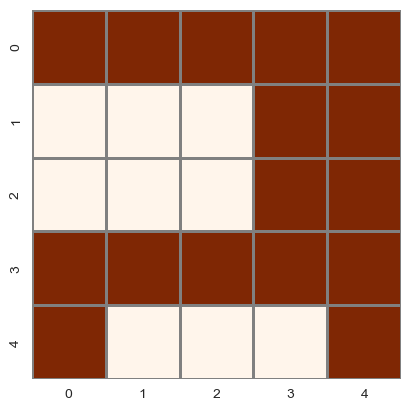

In [962]:
states, actions, scores = generate_session(best_net, best_corner_net, 1, 5) #  forbidden_points,

# Plot
step_through = 4*n - 4
state = states[0,step_through,:]
state_mtx = state.reshape(n,n)

action = actions[0,step_through-1,:]
action_mtx = action.reshape(n,n)

#forbidden = forbidden_points[0,step_through,:]
#forbidden_mtx = forbidden.reshape(n,n)

plot_board(state_mtx)
#plot_board(action_mtx)
#plot_board(forbidden_mtx)

print(glynn(state_mtx.numpy()))

# Model and training

In [26]:
def train(board_size, filename):
    n_sessions = 2000 # number of sessions per iteration
    Learning_rate = 0.001 # learning rate, increase this to converge faster
    corner_learning_rate = 0.0001

    n = board_size

    input_space = n*n
    INF = 1000000

    first_layer_neurons = 128
    second_layer_neurons = 64
    third_layer_neurons = 4
    last_layer_neurons = n*n

    # Defining the neural network architecture
    class MyNet(nn.Module):
        def __init__(self):
            super(MyNet, self).__init__()
            self.fc1 = nn.Linear(input_space, first_layer_neurons)
            self.relu = nn.ReLU()
            self.fc2 = nn.Linear(first_layer_neurons, second_layer_neurons)
            self.relu = nn.ReLU()
            self.fc3 = nn.Linear(second_layer_neurons, third_layer_neurons)
            self.relu = nn.ReLU()
            self.fc4 = nn.Linear(third_layer_neurons, last_layer_neurons)
            self.softmax = nn.Softmax(dim=0)

        def forward(self, x):
            x = self.relu(self.fc1(x))
            x = self.relu(self.fc2(x))
            x = self.relu(self.fc3(x))
            x = self.softmax(self.fc4(x))

            return x

    # Create neural network for corners
    corner_agent = MyNet()

    # Create neural network for all other points
    agent = MyNet()

    # Definte the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    corner_optimizer = optim.SGD(corner_agent.parameters(), lr=corner_learning_rate)
    optimizer = optim.SGD(agent.parameters(), lr=Learning_rate)

    global super_states
    super_states = torch.empty((0, n*n, n*n), dtype=torch.int)
    #global super_forbidden
    #super_forbidden = torch.empty((0, n*n, n*n), dtype=torch.int)
    global super_actions
    super_actions = torch.tensor([], dtype=torch.int)
    global super_rewards
    super_rewards = torch.tensor([])

    counter = 0
    pass_threshold = 1.25 * n

    cur_best_reward = 0
    cur_best_board = torch.zeros([n*n])
    cur_best_game = torch.zeros([n*n, n*n])
    cur_best_actions = torch.zeros([n*n, n*n])

    for i in range(1000):
        states_batch, actions_batch, rewards_batch = generate_session(agent, corner_agent, n_sessions, n) # forbidden_batch
    #    states_batch = states_batch.to(dtype=torch.to)

        if i > 0:
            states_batch = torch.cat((states_batch, super_states), dim=0)
            actions_batch = torch.cat((actions_batch, super_actions), dim=0)
            #fobidden_batch = torch.cat((forbidden_batch, super_forbidden), dim=0)
            #rewards_batch = torch.cat((torch.tensor([cur_best_reward]), rewards_batch, super_rewards), dim=0)
            rewards_batch = torch.cat((rewards_batch, super_rewards), dim=0)

        elite_states, elite_actions = select_elites(states_batch, actions_batch, rewards_batch, percentile = percentile)

        super_sessions = select_super_sessions(states_batch, actions_batch, rewards_batch, percentile = super_percentile)


        super_sessions = [(super_sessions[0][i], super_sessions[1][i], super_sessions[2][i]) for i in range(len(super_sessions[2]))] #, super_sessions[3][i]
        super_sessions.sort(key=lambda x: x[2], reverse=True)
    
        elite_states.to(device)
        
        optimizer.zero_grad()
        outputs = agent(elite_states)
        loss = criterion(outputs, elite_actions.float())
        loss.backward()
        optimizer.step()

        corner_optimizer.zero_grad()
        outputs = corner_agent(elite_states)
        loss = criterion(outputs, elite_actions.float())
        loss.backward()
        corner_optimizer.step()

        super_states = torch.stack([super_sessions[i][0] for i in range(len(super_sessions))])
        super_actions = torch.stack([super_sessions[i][1] for i in range(len(super_sessions))])
        #super_forbidden = torch.stack([super_sessions[i][2] for i in range(len(super_sessions))])
        super_rewards = torch.stack([super_sessions[i][2] for i in range(len(super_sessions))])

        ########

        mean_all_reward = torch.mean(rewards_batch[-100:])
        mean_best_reward = torch.mean(super_rewards)

        #acceptence_threshold = mean_all_reward - 1
        #explore_rate = 1-(i/10000)

        #if mean_best_reward > 1.25*n:
        #    counter+=1

        print("\n" + str(i) +  ". Best individuals: " + str(np.flip(np.sort(super_rewards))))

        #uncomment below line to print out how much time each step in this loop takes.
        #print(	"Mean reward: " + str(mean_all_reward) + "\nSessgen: " + str(sessgen_time) + ", other: " + str(randomcomp_time) + ", select1: " + str(select1_time) + ", select2: " + str(select2_time) + ", select3: " + str(select3_time) +  ", fit: " + str(fit_time) + ", score: " + str(score_time))

        #uncomment below line to print out the mean best reward
        print("Mean best reward: " + str(mean_best_reward))
        #print("Best reward: " + str(np.flip(np.sort(super_rewards))[0]))
    
        # Make a new folder if 'Data' folder does not exist
        #if not os.path.exists('Data'):
        #    os.makedirs('Data')

        max_index = torch.argmax(super_rewards)
        #print('old best: ' + str(cur_best_reward))
        #print('test super rewards max index: ' + str(super_rewards[max_index]))
        if super_rewards[max_index] > cur_best_reward:
            cur_best_reward = super_rewards[max_index]
            #print('new best: ' + str(cur_best_reward))
            #cur_best_board = final_board_state(super_states[max_index]).numpy()
            cur_best_board = super_states[max_index, 4*n-4].numpy()
            cur_best_game = super_states[max_index]
            cur_best_actions = super_actions[max_index]

            best_states_set = set()
            best_states_set.add(str(cur_best_board))

            with open(os.path.join('Data_two_agent', str(filename)+'_best_board_timeline'+'.txt'), 'a') as f:
                f.write(str(convert_to_board(cur_best_board, n))) #, construction)))
                f.write("\n")
            with open(os.path.join('Data_two_agent', str(filename)+'_best_reward_timeline'+'.txt'), 'a') as f:
                f.write(str(cur_best_reward))
                f.write("\n")

            #with open(os.path.join('Data', str(filename)+'_best_board_timeline'+'.txt'), 'a') as f:
            #    f.write(str(convert_to_board(cur_best_board, n))) #, construction)))
            #    f.write("\n")
            
            #with open(os.path.join('Data', str(filename)+'_best_reward_timeline'+'.txt'), 'a') as f:
            #    f.write(str(cur_best_reward))
            #    f.write("\n")
            
        #    counter = 0
        
        if super_rewards[max_index] == cur_best_reward:
        #    counter += 1

            cur_best_board = super_states[max_index, 4*n-4].numpy()
            if str(cur_best_board) not in best_states_set:
                best_states_set.add(str(cur_best_board))
                #print('Glynn: '+str(glynn(cur_best_board.reshape(n,n))))
                #print(str(cur_best_board))
                with open(os.path.join('Data_two_agent', str(filename)+'_best_board_timeline'+'.txt'), 'a') as f:
                    f.write(str(convert_to_board(cur_best_board, n))) #, construction)))
                    f.write("\n")
                with open(os.path.join('Data_two_agent', str(filename)+'_best_reward_timeline'+'.txt'), 'a') as f:
                    f.write(str(cur_best_reward))
                    f.write("\n")
                
        #   cur_best_board = final_board_state(super_states[max_index]).numpy()
            #if str(cur_best_board) not in best_states_set:
            #    with open(os.path.join('Data', str(filename)+'_best_board_timeline'+'.txt'), 'a') as f:
            #        f.write(str(convert_to_board(cur_best_board, n))) #, construction)))
            #        f.write("\n")
            #    with open(os.path.join('Data', str(filename)+'_best_reward_timeline'+'.txt'), 'a') as f:
            #        f.write(str(cur_best_reward))
            #        f.write("\n")
        
        #if board_type == "line" and cur_best_reward == 4*n:
        #    return net
        
        #if counter > 1000:
        #    return net
        '''
        if write_all:
            if (i%20 == 1): #Write all important info to files every 20 iterations
                with open(os.path.join('Data', str(filename)+'_best_species'+'.txt'), 'w') as f:
                    for game in super_states:
                        f.write(str(convert_to_board(final_board_state(game).numpy(), n))) #, construction)))
                        f.write("\n")
                with open(os.path.join('Data', str(filename)+'_best_species_rewards'+'.txt'), 'w') as f:
                    for item in super_rewards:
                        f.write(str(item))
                        f.write("\n")
                with open(os.path.join('Data', str(filename)+'_best_100_rewards'+'.txt'), 'a') as f:
                    f.write(str(mean_all_reward)+"\n")
                with open(os.path.join('Data', str(filename)+'_best_super_rewards'+'.txt'), 'a') as f:
                    f.write(str(mean_best_reward)+"\n")
                if (i%200==2):
                    with open(os.path.join('Data', str(filename)+'_best_species_timeline'+'.txt'), 'a') as f:
                        f.write(str(convert_to_board(final_board_state(super_states[max_index]).numpy(), n))) #, construction)))
                        f.write("\n")
        if write_best:
            if mean_best_reward > pass_threshold:
                with open(os.path.join('Data', str(filename)+'_best_species'+'.txt'), 'w') as f:
                    for game in super_states:
                        f.write(str(convert_to_board(final_board_state(game).numpy(), n))) #,construction)))
                        f.write("\n")
                with open(os.path.join('Data', str(filename)+'_best_species_rewards'+'.txt'), 'w') as f:
                    for item in super_rewards:
                        f.write(str(item))
                        f.write("\n")
                with open(os.path.join('Data', str(filename)+'_best_100_rewards'+'.txt'), 'a') as f:
                    f.write(str(mean_all_reward)+"\n")
                with open(os.path.join('Data', str(filename)+'_best_super_rewards'+'.txt'), 'a') as f:
                    f.write(str(mean_best_reward)+"\n")
                if (i%200==2):
                    max_index = torch.argmax(super_rewards)
                    with open(os.path.join('Data', str(filename)+'_best_species_timeline'+'.txt'), 'a') as f:
                        f.write(str(convert_to_board(final_board_state(super_states[max_index]).numpy(), n))) #, construction)))
                        f.write("\n")

        if counter > 1000:
            if mean_best_reward > pass_threshold:
                with open(os.path.join('Data', str(filename)+'_best_species'+'.txt'), 'w') as f:
                    for game in super_states:
                        f.write(str(convert_to_board(final_board_state(game).numpy(), n))) #, construction)))
                        f.write("\n")
                with open(os.path.join('Data', str(filename)+'_best_species_rewards'+'.txt'), 'w') as f:
                    for item in super_rewards:
                        f.write(str(item))
                        f.write("\n")
                with open(os.path.join('Data', str(filename)+'_best_100_rewards'+'.txt'), 'a') as f:
                    f.write(str(mean_all_reward)+"\n")
                with open(os.path.join('Data', str(filename)+'_best_super_rewards'+'.txt'), 'a') as f:
                    f.write(str(mean_best_reward)+"\n")
                if (i%200==2):
                    max_index = torch.argmax(super_rewards)
                    with open(os.path.join('Data', str(filename)+'_best_species_timeline'+'.txt'), 'a') as f:
                        f.write(str(convert_to_board(final_board_state(super_states[max_index]).numpy(), n))) #, construction)))
                        f.write("\n
        #        return net
        '''
    print(cur_best_reward)
    return agent, corner_agent, cur_best_game

16.0


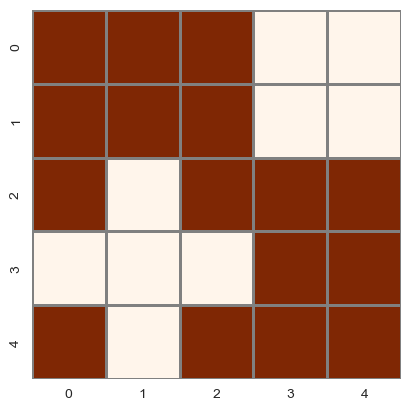

In [1052]:
states, actions, scores = generate_session(best_net, best_corner_net, 1, 5) #  forbidden_points,

# Plot
step_through = 4*n - 4
state = states[0,step_through,:]
state_mtx = state.reshape(n,n)

action = actions[0,step_through-1,:]
action_mtx = action.reshape(n,n)

#forbidden = forbidden_points[0,step_through,:]
#forbidden_mtx = forbidden.reshape(n,n)

plot_board(state_mtx)
#plot_board(action_mtx)
#plot_board(forbidden_mtx)

print(glynn(state_mtx.numpy()))

In [27]:
n = 10
filename = "10x10_2000n"
best_net, best_corner_net, best_game = train(n, filename)


0. Best individuals: [182.  72.  72.  52.  48.  36.  24.  20.  20.  16.  16.  10.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]
Mean best reward: tensor(5.6800)

1. Best individuals: [110.  32.  32.  20.  20.  16.  16.   4.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0

In [968]:
final_board_state(best_game[4*n - 4])

tensor(1.)

16.0


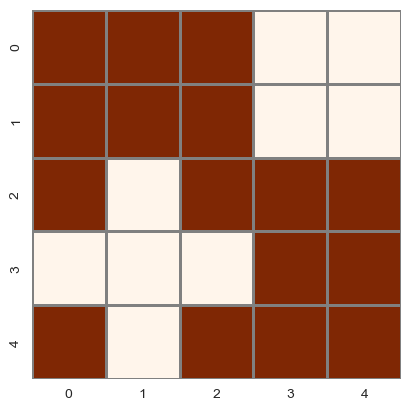

In [969]:
# Plot
state = best_game[4*n-4,:]
state_mtx = state.reshape(n,n)

#action = actions[0,step_through-1,:]
#action_mtx = action.reshape(6,6)

#forbidden = forbidden_points[0,step_through,:]
#forbidden_mtx = forbidden.reshape(6,6)

#plot_board(state_mtx)
#plot_board(action_mtx)
plot_board(state_mtx)

print(glynn(state_mtx.numpy()))

In [943]:
write_all = False
write_best = True

In [734]:
print(corner_list)
print(target_corner_num)
print(step)

[1, 14, 23, 63]
4
19


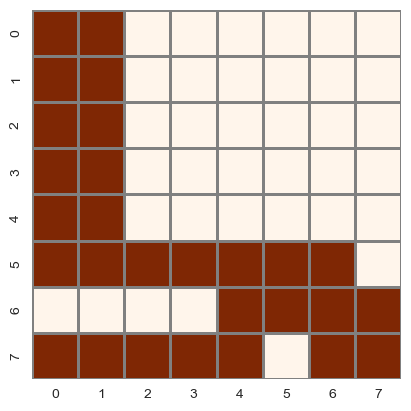

In [746]:
# Plot
step_through = step
state = states[0,step_through,:]
state_mtx = state.reshape(n,n)

#action = actions[0,step_through-1,:]
#action_mtx = action.reshape(6,6)

#forbidden = forbidden_points[0,step_through,:]
#forbidden_mtx = forbidden.reshape(6,6)

#plot_board(state_mtx)
#plot_board(action_mtx)
plot_board(state_mtx)

In [892]:
print(state_mtx.numpy())
#print(glynn(state_mtx))

[[1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1.]]


In [751]:
print(glynn(state_mtx.numpy()))

0.0


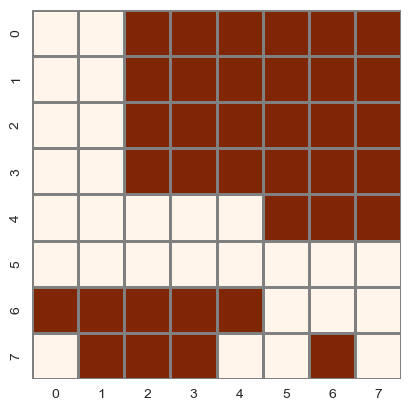

In [743]:
# Plot
step_through = step
#state = states[0,step_through,:]
#state_mtx = state.reshape(6,6)

#action = actions[0,step_through-1,:]
#action_mtx = action.reshape(6,6)

forbidden = forbidden_points[0,step_through,:]
forbidden_mtx = forbidden.reshape(n,n)

#plot_board(state_mtx)
#plot_board(action_mtx)
plot_board(forbidden_mtx)

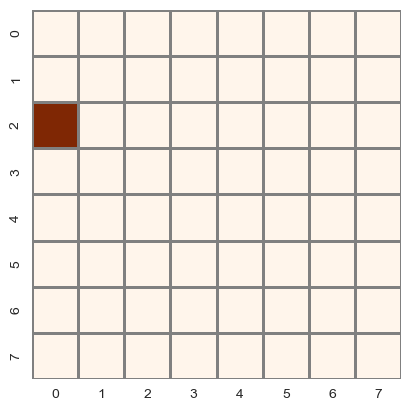

In [744]:
# Plot
step_through = step
#state = states[0,step_through,:]
#state_mtx = state.reshape(6,6)

action = actions[0,step_through-1,:]
action_mtx = action.reshape(n,n)

#forbidden = forbidden_points[0,step_through,:]
#forbidden_mtx = forbidden.reshape(6,6)

#plot_board(state_mtx)
plot_board(action_mtx)
#plot_board(forbidden_mtx)

In [739]:
print(step)
print(corner_list)

29
[1, 14, 23, 63]


In [741]:

# add remaining points
terminal = False
while step < 4*n - 4: #4*n - 4:
    step+=1
    cur_state = states[i,step-1, :]
    cur_forbidden = forbidden_points[i,step-1, :]

    #tic = time.time()
    #output = agent(cur_state)
    #pred_time += time.time() - tic

    output = agent(cur_state)

    #tic = time.time()
    new_state, action, new_forbidden_state = add_point(cur_state, output, cur_forbidden, corner_list, n)
    #play_time += time.time() - tic

    #tic = time.time()
    #if terminal:
    #    total_score[i] = cur_state.sum()
    #    continue
    actions[i,step-1, :] = action
    #scoreUpdate_time += time.time() - tic

    #tic = time.time()
    states[i,step, :] = new_state
    #recordsess_time += time.time() - tic

    forbidden_points[i,step, :] = new_forbidden_state


# Part by part

In [456]:
# (nth session, always 4*n - 4 steps, always n*n board)
states = torch.zeros((n_sessions, 4*n - 4, n*n))
actions = torch.zeros((n_sessions, 4*n - 4, n*n))
forbidden_points = torch.zeros((n_sessions, 4*n - 4, n*n))
corners = torch.zeros((n_sessions, 4*n - 4, n*n))

i = 0

In [457]:
step = 0

while step < 3:
    step += 1
    cur_state = states[i,step-1, :]

    new_state, action = add_free_points(cur_state, n, step)
    
    actions[i,step-1, :] = action
    states[i,step, :] = new_state

In [458]:
# add corners
corner_num = 0
corner_list = [0]*(n-2) # there can be at most n-2 corners

row_boundary, col_boundary = 0, 1

row_zero_set = False
terminal = False
while not terminal:
    step += 1
    cur_state = states[i,step-1, :]

    output = corner_agent(cur_state)

    new_state, action, terminal, row_added, col_added = add_corner(cur_state, output, n, row_boundary, col_boundary)
    
    # Ensures that a corner is always set in first row. If the lower block is entered, essentially sets (1,2), 1-indexed, as the first corner
    # then artifically using the above point as the next step. The lower black can only be entered once.
    if row_added == 0:
        row_zero_set = True
    if not row_zero_set:
        cur_state = torch.clone(states[i,step-1, :])
        cur_state[1] = 1

        actions[i,step-1, 1] = 1
        states[i,step, :] = cur_state
        corners[i,step, 1] = 1
    
        corner_list[corner_num] = 1 # the first corner is at index 1
        corner_num += 1
    
        step += 1
        row_zero_set = True

        new_state[1] = 1
    ''' need to account for attempted corners in second column, other than index 1 '''
    corner_index = row_added*n + col_added
    corner_list[corner_num] = corner_index
    corners[i,step, corner_index] = 1

    corner_num += 1

    row_boundary = row_added + 1
    col_boundary = col_added + 1

    actions[i,step-1, :] = action
    states[i,step, :] = new_state

In [459]:
# prune corner list
corner_list = corner_list[:corner_num]
corner_list.sort()

In [460]:
# add induced corners
for corner_index in corner_list:
    step += 1
    cur_state = torch.clone(states[i,step-1, :])
    #cur_forbidden = torch.clone(forbidden_points[i,step-1, :])

    corner_row = corner_index//n
    corner_col = corner_index%n
    # induced corner = (i+1, j-1) -> (i+1)n + (j-1), where i=row and j=col
    induced_corner_index = (corner_row+1)*n + (corner_col-1)
    cur_state[induced_corner_index] = 1

    actions[i,step-1, induced_corner_index] = 1
    states[i,step, :] = cur_state

In [461]:
# add zig-zag and upper forbidden points
corner_list.append(n**2-1) # n^2-1 is not a corner, but we append it to work with while-loop below
corner_list.append(float('inf'))
cur_path_element = 1 # first element on the zig-zag path, besides upper-left corner
target_corner_num = 0
target_corner = corner_list[target_corner_num]

# first row
while cur_path_element != target_corner:
    # action
    step += 1
    cur_state = torch.clone(states[i,step-1, :])
    cur_state[cur_path_element] = 1

    actions[i,step-1, cur_path_element] = 1
    states[i,step, :] = cur_state

    cur_path_element += 1 # step element by one row, fixing column

# update forbidden states
cur_forbidden_state = torch.clone(forbidden_points[i,step-1, :])
for forbidden_index in range(cur_path_element+1, n):
    cur_forbidden_state[forbidden_index] = 1 
forbidden_points[i, step, :] = cur_forbidden_state

target_corner_num += 1
target_corner = corner_list[target_corner_num]  

while cur_path_element < n**2-n-1:
    target_row = target_corner//n
    #target_col = target_corner%n

    cur_row = cur_path_element//n
    cur_col = cur_path_element%n

    while cur_path_element != target_corner: # incorrect row OR incorrect column
        if cur_row != target_row: # must move row
            # update forbidden states
            cur_forbidden_state = torch.clone(forbidden_points[i,step-1, :])
            for forbidden_index in range(cur_path_element+1, cur_row*n + n):
                cur_forbidden_state[forbidden_index] = 1 
            forbidden_points[i, step, :] = cur_forbidden_state
            # action
            step += 1
            cur_state = torch.clone(states[i,step-1, :])
            cur_path_element += n # step element by one row, fixing column
            cur_state[cur_path_element] = 1

            actions[i,step-1, cur_path_element] = 1
            states[i,step, :] = cur_state

            cur_row += 1
        else: # cur_col != target_col, i.e, correct row but must move column
            # action
            cur_path_element += 1
            if cur_path_element != target_corner:
                step += 1
                cur_state = torch.clone(states[i,step-1, :])
                #cur_path_element += 1 # step element by one column, fixing row
                cur_state[cur_path_element] = 1

                actions[i,step-1, cur_path_element] = 1
                states[i,step, :] = cur_state

                cur_col += 1
    target_corner_num += 1
    target_corner = corner_list[target_corner_num]   

# Plots

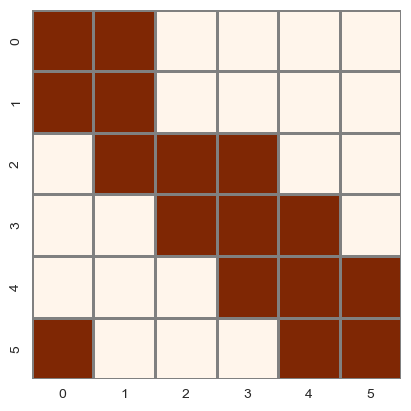

In [465]:
step_through = step
state = states[0,step_through,:]
state_mtx = state.reshape(6,6)

action = actions[0,step_through-1,:]
action_mtx = action.reshape(6,6)

forbidden = forbidden_points[0,step_through,:]
forbidden_mtx = forbidden.reshape(6,6)

plot_board(state_mtx)

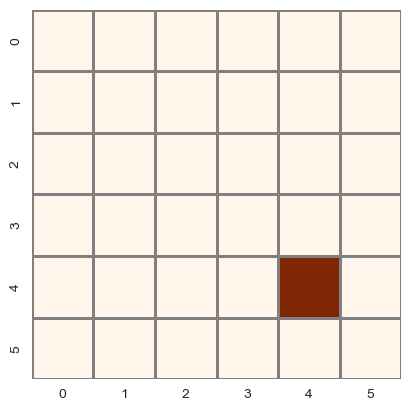

In [464]:
plot_board(action_mtx)

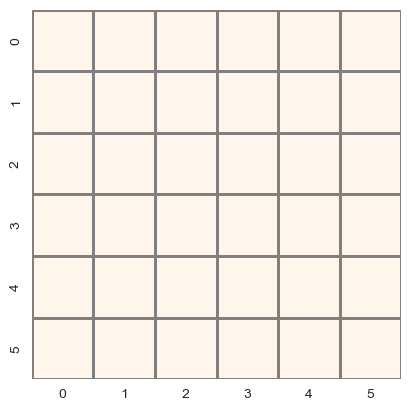

In [466]:
plot_board(forbidden_mtx)

# Helper function to make plots

In [4]:
def plot_board(matrix):

    n = len(matrix)
    data = np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            if matrix[i][j] == 1:
                data[i][j] = 1
    sns.set_style("whitegrid", {'axes.grid': False})
    sns.heatmap(data, cmap='Oranges', square=True, cbar=False, linewidth=1,
                linecolor='gray', annot=False, fmt='g')

# Model definition

In [544]:
n_sessions = 500 # number of sessions per iteration
Learning_rate = 0.001 # learning rate, increase this to converge faster

n = 8

input_space = n*n
INF = 1000000

first_layer_neurons = 128
second_layer_neurons = 64
third_layer_neurons = 4
last_layer_neurons = n*n

# Defining the neural network architecture
class MyNet(nn.Module):
    def __init__(self):
        super(MyNet, self).__init__()
        self.fc1 = nn.Linear(input_space, first_layer_neurons)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(first_layer_neurons, second_layer_neurons)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(second_layer_neurons, third_layer_neurons)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(third_layer_neurons, last_layer_neurons)
        self.softmax = nn.Softmax(dim=0)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.softmax(self.fc4(x))

        return x

# Create neural network for corners
corner_agent = MyNet()

# Create neural network for all other points
agent = MyNet()

# Definte the loss function and optimizer
criterion = nn.CrossEntropyLoss()
corner_optimizer = optim.SGD(corner_agent.parameters(), lr=Learning_rate)
optimizer = optim.SGD(agent.parameters(), lr=Learning_rate)
